# Using a Kerchunk catalog to open the GAMAR archive

In this example, we use a Kerchunk catalog generated on the HPC infrastructure. The same workflow can then open the data either directly on the HPC filesystem, or over HTTPS using the DATARMOR export service that exposes /scale/project/lops-oh-fair2adapt/ at https://data-fair2adapt.ifremer.fr/



Here are the list of kerchunk files created by fred

#open_virtual_dataset version using ds.virtualize.to_kerchunk(outfile, format="json")
#KERCHUNK_CATALOG='/scale/project/lops-oh-fair2adapt/fpaul/tmp/riomar.json'
#KERCHUNK_CATALOG='/scale/project/lops-oh-fair2adapt/fpaul/tmp/riomar_3months.json'
#KERCHUNK_CATALOG='https://data-fair2adapt.ifremer.fr/fpaul/tmp/riomar_3months.json'

#or, http urls inside (!timeout si depuis ifremer...):
#KERCHUNK_CATALOG='/scale/project/lops-oh-fair2adapt/fpaul/tmp/riomar_sed_web.json'  # timeout

#or, kerchunk multizarr version  KO / plot VIDE si time_counter != 0 !!
#KERCHUNK_CATALOG='/scale/project/lops-oh-fair2adapt/fpaul/tmp/riomar.kerchunk_multizarr.json'


In [1]:
%%time
# this takes 4 s
#
import json
import fsspec
from pathlib import Path

#import fsspec
import xarray as xr

HPC_PREFIX    = "/scale/project/lops-oh-fair2adapt/"
HTTPS_PREFIX  = "https://data-fair2adapt.ifremer.fr/"
CATALOG_PATH  = "fpaul/tmp/riomar_3months.json"
OUT_PARQUET   = "riomar_3months_.parq"   # local parquet refs cache

def patch_kc_refs_inplace(kc, hpc_prefix=HPC_PREFIX, https_prefix=HTTPS_PREFIX):
    refs = kc.get("refs", kc.get("references"))
    if refs is None:
        raise KeyError("Can't find 'refs' (or 'references') in kerchunk JSON")

    def patch_target(x):
        if isinstance(x, str) and x.startswith(hpc_prefix):
            return https_prefix + x[len(hpc_prefix):]
        return x

    for k, v in list(refs.items()):
        if isinstance(v, list) and v and isinstance(v[0], str):
            refs[k] = [patch_target(v[0])] + v[1:]
        elif isinstance(v, str):
            refs[k] = patch_target(v)

    kc["refs"] = refs
    return kc


# ------------------------------
# 1) HPC mode: open directly
# ------------------------------
if Path(HPC_PREFIX).exists():
    KERCHUNK_CATALOG = HPC_PREFIX + CATALOG_PATH
    print("Running in HPC mode:", KERCHUNK_CATALOG)

    ds = xr.open_dataset(KERCHUNK_CATALOG, engine="kerchunk", chunks={})

# ------------------------------
# 2) HTTPS mode: prefer local parquet cache if present
# ------------------------------
else:
    KERCHUNK_CATALOG = HTTPS_PREFIX + CATALOG_PATH
    print("Running in HTTPS mode:", KERCHUNK_CATALOG)
    # If parquet refs already exist locally, open them (fast path)
    # This part is commented since on the fly transformation is faster than loading the parquet file in actual config
    # (check why at some point) 
    # Loading from local parquet is also slower than loading json and convert the path on the fly...
    # thus i deactivate the if here
    #if Path(OUT_PARQUET).exists():
    if False and Path(OUT_PARQUET).exists():
        print(f"✅ Found local parquet refs: ./{OUT_PARQUET} -> opening that")
        xr.open_dataset(OUT_PARQUET, engine="kerchunk", chunks={})

    # Else: fetch JSON, patch refs to https, open, AND write parquet refs cache
    else:
        print(f"ℹ️ No local parquet refs found at ./{OUT_PARQUET} -> creating them from JSON")

        with fsspec.open(KERCHUNK_CATALOG, "rt") as f:
            kc = json.load(f)

        kc = patch_kc_refs_inplace(kc)

        # open now (from in-memory dict)
        ds = xr.open_dataset(kc, engine="kerchunk", chunks={})

        ## write parquet refs cache for next time
        #import kerchunk.df as kcdf
        #kcdf.refs_to_dataframe(kc, OUT_PARQUET)
        #print("✅ Wrote kerchunk parquet refs to:", OUT_PARQUET)

ds

Running in HTTPS mode: https://data-fair2adapt.ifremer.fr/fpaul/tmp/riomar_3months.json
ℹ️ No local parquet refs found at ./riomar_3months_.parq -> creating them from JSON
CPU times: user 1.65 s, sys: 421 ms, total: 2.07 s
Wall time: 25.2 s


<xarray.Dataset> Size: 866GB
Dimensions:              (time_counter: 2208, s_rho: 40, s_w: 41, y_rho: 838,
                          x_rho: 727, y_u: 838, x_u: 726, y_v: 837, x_v: 727,
                          axis_nbounds: 2)
Coordinates: (12/19)
  * time_counter         (time_counter) datetime64[ns] 18kB 2023-12-01T00:48:...
    time_instant         (time_counter) datetime64[ns] 18kB dask.array<chunksize=(2208,), meta=np.ndarray>
  * s_rho                (s_rho) float32 160B -0.9875 -0.9625 ... -0.0125
  * s_w                  (s_w) float32 164B -1.0 -0.975 -0.95 ... -0.025 nan
  * y_rho                (y_rho) float32 3kB 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
  * x_rho                (x_rho) float32 3kB 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    ...                   ...
  * x_v                  (x_v) float32 3kB 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    nav_lat_v            (y_v, x_v) float32 2MB dask.array<chunksize=(837, 727), meta=np.ndarray>
    nav_lon_v            (y_v, x_v) float32 2MB dask.array<chunksize=(837, 727), meta=np.ndarray>
  * axis_nbounds         (axis_nbounds) float32 8B 0.0 0.0
    time_instant_bounds  (time_counter, axis_nbounds) datetime64[ns] 35kB dask.array<chunksize=(1, 2), meta=np.ndarray>
    time_counter_bounds  (time_counter, axis_nbounds) datetime64[ns] 35kB dask.array<chunksize=(1, 2), meta=np.ndarray>
Data variables: (12/14)
    hc                   (time_counter) float32 9kB dask.array<chunksize=(1,), meta=np.ndarray>
    theta_s              (time_counter) float32 9kB dask.array<chunksize=(1,), meta=np.ndarray>
    theta_b              (time_counter) float32 9kB dask.array<chunksize=(1,), meta=np.ndarray>
    Tcline               (time_counter) float32 9kB dask.array<chunksize=(1,), meta=np.ndarray>
    Vtransform           (time_counter) float32 9kB dask.array<chunksize=(1,), meta=np.ndarray>
    Cs_r                 (time_counter, s_rho) float32 353kB dask.array<chunksize=(1, 40), meta=np.ndarray>
    ...                   ...
    sc_w                 (time_counter, s_w) float32 362kB dask.array<chunksize=(1, 41), meta=np.ndarray>
    zeta                 (time_counter, y_rho, x_rho) float32 5GB dask.array<chunksize=(1, 838, 727), meta=np.ndarray>
    u                    (time_counter, s_rho, y_u, x_u) float32 215GB dask.array<chunksize=(1, 40, 838, 726), meta=np.ndarray>
    v                    (time_counter, s_rho, y_v, x_v) float32 215GB dask.array<chunksize=(1, 40, 837, 727), meta=np.ndarray>
    temp                 (time_counter, s_rho, y_rho, x_rho) float32 215GB dask.array<chunksize=(1, 40, 838, 727), meta=np.ndarray>
    salt                 (time_counter, s_rho, y_rho, x_rho) float32 215GB dask.array<chunksize=(1, 40, 838, 727), meta=np.ndarray>
Attributes: (12/42)
    name:           GAMAR_GLORYS_1h_inst
    description:    Created by xios
    Conventions:    CF-1.6
    title:          GAMAR_GLORYS
    rst_file:       croco_rst.nc
    grd_file:       croco_grd.nc
    ...             ...
    gamma2_expl:    Slipperiness parameter
    x_sponge:       0.0
    v_sponge:       0.0
    sponge_expl:    Sponge parameters : extent (m) & viscosity (m2.s-1)
    SRCS:           main.F step.F read_inp.F timers_roms.F init_scalars.F ini...
    CPP-options:    REGIONAL GAMAR MPI TIDES OBC_WEST OBC_NORTH XIOS USE_CALE...

In [2]:
ds=ds[['temp','salt','zeta']].assign_coords(
    nav_lon_rho=ds["nav_lon_rho"].load(),
    nav_lat_rho=ds["nav_lat_rho"].load(),
)
ds

<xarray.Dataset> Size: 436GB
Dimensions:       (time_counter: 2208, s_rho: 40, y_rho: 838, x_rho: 727)
Coordinates:
  * time_counter  (time_counter) datetime64[ns] 18kB 2023-12-01T00:48:10 ... ...
    time_instant  (time_counter) datetime64[ns] 18kB dask.array<chunksize=(2208,), meta=np.ndarray>
  * s_rho         (s_rho) float32 160B -0.9875 -0.9625 ... -0.0375 -0.0125
  * y_rho         (y_rho) float32 3kB 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
  * x_rho         (x_rho) float32 3kB 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    nav_lat_rho   (y_rho, x_rho) float32 2MB -1.0 -1.0 -1.0 ... 50.87 50.87
    nav_lon_rho   (y_rho, x_rho) float32 2MB -1.0 -1.0 -1.0 ... 1.653 1.667 1.68
Data variables:
    temp          (time_counter, s_rho, y_rho, x_rho) float32 215GB dask.array<chunksize=(1, 40, 838, 727), meta=np.ndarray>
    salt          (time_counter, s_rho, y_rho, x_rho) float32 215GB dask.array<chunksize=(1, 40, 838, 727), meta=np.ndarray>
    zeta          (time_counter, y_rho, x_rho) float32 5GB dask.array<chunksize=(1, 838, 727), meta=np.ndarray>
Attributes: (12/42)
    name:           GAMAR_GLORYS_1h_inst
    description:    Created by xios
    Conventions:    CF-1.6
    title:          GAMAR_GLORYS
    rst_file:       croco_rst.nc
    grd_file:       croco_grd.nc
    ...             ...
    gamma2_expl:    Slipperiness parameter
    x_sponge:       0.0
    v_sponge:       0.0
    sponge_expl:    Sponge parameters : extent (m) & viscosity (m2.s-1)
    SRCS:           main.F step.F read_inp.F timers_roms.F init_scalars.F ini...
    CPP-options:    REGIONAL GAMAR MPI TIDES OBC_WEST OBC_NORTH XIOS USE_CALE...

In [4]:
def polygon_mask(lon2d, lat2d, poly):
    """
    Return DataArray mask True inside poly, same shape as lon2d/lat2d.
    poly: a FILLED shapely Polygon/MultiPolygon in EPSG:4326 lon/lat.
    """
    try:
        from shapely import contains_xy  # shapely>=2
        # contains_xy accepts numpy arrays directly
        mask = contains_xy(poly, lon2d.values, lat2d.values)
    except Exception:
        # fallback: matplotlib path on exterior only (good if you removed holes already)
        from matplotlib.path import Path
        x, y = poly.exterior.xy
        path = Path(np.column_stack([x, y]))
        pts = np.column_stack([lon2d.values.ravel(), lat2d.values.ravel()])
        mask = path.contains_points(pts).reshape(lon2d.shape)

    return xr.DataArray(mask, coords=lon2d.coords, dims=lon2d.dims, name="mask")

In [5]:
import geopandas as gpd
import numpy as np
import xarray as xr

def polygon_mask(lon2d, lat2d, poly):
    """
    Return DataArray mask True inside poly, same shape as lon2d/lat2d.
    lon2d/lat2d: xarray.DataArray or numpy array (2D)
    poly: shapely Polygon/MultiPolygon in EPSG:4326 lon/lat
    """
    # get numpy arrays
    lon = lon2d.values if hasattr(lon2d, "values") else np.asarray(lon2d)
    lat = lat2d.values if hasattr(lat2d, "values") else np.asarray(lat2d)

    try:
        from shapely import contains_xy  # shapely>=2
        mask = contains_xy(poly, lon, lat)
    except Exception:
        # fallback (exterior only)
        from matplotlib.path import Path
        x, y = poly.exterior.xy
        path = Path(np.column_stack([x, y]))
        pts = np.column_stack([lon.ravel(), lat.ravel()])
        mask = path.contains_points(pts).reshape(lon.shape)

    # rebuild DataArray with coords if lon2d is xarray
    if hasattr(lon2d, "coords"):
        return xr.DataArray(mask, coords=lon2d.coords, dims=lon2d.dims, name="mask")
    else:
        return xr.DataArray(mask, dims=("y", "x"), name="mask")

        
gdf=gpd.read_file("outer_boundary.geojson", driver="GeoJSON")
poly = gdf.geometry.iloc[0]  
#dsds.isel(  time_counter=slice(0,2))[['temp','salt','zeta']]

mask = polygon_mask(ds["nav_lon_rho"], ds["nav_lat_rho"], poly)
ds = ds.assign_coords(mask=mask.astype(bool))
mask

/Users/todaka/micromamba/envs/pangeo/lib/python3.13/site-packages/pyogrio/raw.py:198: RuntimeWarning: driver GeoJSON does not support open option DRIVER
  return ogr_read(


<xarray.DataArray 'mask' (y_rho: 838, x_rho: 727)> Size: 609kB
array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]], shape=(838, 727))
Coordinates:
  * y_rho        (y_rho) float32 3kB 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
  * x_rho        (x_rho) float32 3kB 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    nav_lat_rho  (y_rho, x_rho) float32 2MB -1.0 -1.0 -1.0 ... 50.87 50.87 50.87
    nav_lon_rho  (y_rho, x_rho) float32 2MB -1.0 -1.0 -1.0 ... 1.653 1.667 1.68

In [21]:
ds_temp =ds.where(mask,drop=True)
ds_temp


<xarray.Dataset> Size: 2GB
Dimensions:       (time_counter: 2208, s_rho: 40, y_rho: 50, x_rho: 68)
Coordinates:
  * time_counter  (time_counter) datetime64[ns] 18kB 2023-12-01T00:48:10 ... ...
    time_instant  (time_counter) datetime64[ns] 18kB dask.array<chunksize=(2208,), meta=np.ndarray>
  * s_rho         (s_rho) float32 160B -0.9875 -0.9625 ... -0.0375 -0.0125
  * y_rho         (y_rho) float32 200B 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
  * x_rho         (x_rho) float32 272B 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    nav_lat_rho   (y_rho, x_rho) float32 14kB 46.94 46.94 46.94 ... -1.0 -1.0
    nav_lon_rho   (y_rho, x_rho) float32 14kB -2.853 -2.84 -2.827 ... -1.0 -1.0
Data variables:
    temp          (time_counter, s_rho, y_rho, x_rho) float32 1GB dask.array<chunksize=(1, 40, 50, 68), meta=np.ndarray>
    salt          (time_counter, s_rho, y_rho, x_rho) float32 1GB dask.array<chunksize=(1, 40, 50, 68), meta=np.ndarray>
    zeta          (time_counter, y_rho, x_rho) float32 30MB dask.array<chunksize=(1, 50, 68), meta=np.ndarray>
Attributes: (12/42)
    name:           GAMAR_GLORYS_1h_inst
    description:    Created by xios
    Conventions:    CF-1.6
    title:          GAMAR_GLORYS
    rst_file:       croco_rst.nc
    grd_file:       croco_grd.nc
    ...             ...
    gamma2_expl:    Slipperiness parameter
    x_sponge:       0.0
    v_sponge:       0.0
    sponge_expl:    Sponge parameters : extent (m) & viscosity (m2.s-1)
    SRCS:           main.F step.F read_inp.F timers_roms.F init_scalars.F ini...
    CPP-options:    REGIONAL GAMAR MPI TIDES OBC_WEST OBC_NORTH XIOS USE_CALE...

In [18]:
lat = ds_temp["nav_lat_rho"]
lon = ds_temp["nav_lon_rho"]

valid = (lat != -1) & (lon != -1)  # or (lat > -90) & (lon > -180) if you prefer

lat_min = lat.where(valid).min().item()
lat_max = lat.where(valid).max().item()
lon_min = lon.where(valid).min().item()
lon_max = lon.where(valid).max().item()

lat_min, lat_max, lon_min, lon_max

(46.943626403808594,
 47.38785171508789,
 -2.8533332347869873,
 -1.9600000381469727)

In [ ]:
ds_temp.temp.isel(time_counter=0, s_rho=0).plot(
    y='nav_lat_rho', x='nav_lon_rho'
    ,  ylim=(lat_min, lat_max)
, xlim = (lon_min, lon_max)
)

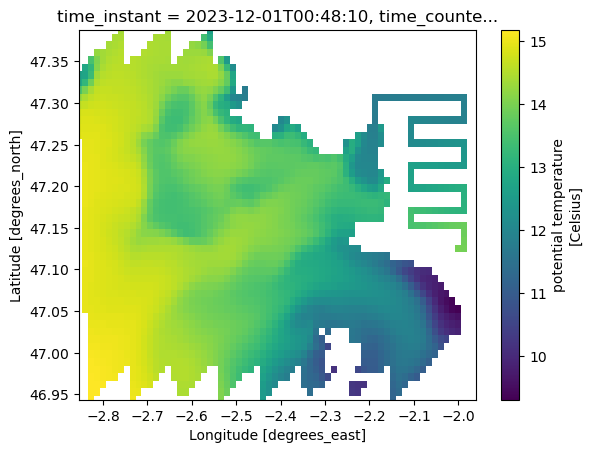

## Create the region interest fro the demo
The demo requires region of `x_rho =slice(390,452), y_rho =slice(400,430) )[['temp','salt','zeta']]`
We create small slice of it and save it to local to make some regridding test on the next notebook 'simple_regrid.ipynb'


In [7]:
n=5
small_ds=ds.isel(x_rho =slice(390-n,452+n), 
                 y_rho =slice(400-n,430+n),
                 #time_counter=0
                 time_counter=slice(0,2)
                )[['temp','salt','zeta']]
#chunk(chunks={"time_counter":"10M"}).persist() 
small_ds



<xarray.Dataset> Size: 2MB
Dimensions:       (time_counter: 2, s_rho: 40, y_rho: 40, x_rho: 72)
Coordinates:
  * time_counter  (time_counter) datetime64[ns] 16B 2023-12-01T00:48:10 2023-...
    time_instant  (time_counter) datetime64[ns] 16B dask.array<chunksize=(2,), meta=np.ndarray>
  * s_rho         (s_rho) float32 160B -0.9875 -0.9625 ... -0.0375 -0.0125
  * y_rho         (y_rho) float32 160B 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
  * x_rho         (x_rho) float32 288B 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    nav_lat_rho   (y_rho, x_rho) float32 12kB dask.array<chunksize=(40, 72), meta=np.ndarray>
    nav_lon_rho   (y_rho, x_rho) float32 12kB dask.array<chunksize=(40, 72), meta=np.ndarray>
Data variables:
    temp          (time_counter, s_rho, y_rho, x_rho) float32 922kB dask.array<chunksize=(1, 40, 40, 72), meta=np.ndarray>
    salt          (time_counter, s_rho, y_rho, x_rho) float32 922kB dask.array<chunksize=(1, 40, 40, 72), meta=np.ndarray>
    zeta          (time_counter, y_rho, x_rho) float32 23kB dask.array<chunksize=(1, 40, 72), meta=np.ndarray>
Attributes: (12/42)
    name:           GAMAR_GLORYS_1h_inst
    description:    Created by xios
    Conventions:    CF-1.6
    title:          GAMAR_GLORYS
    rst_file:       croco_rst.nc
    grd_file:       croco_grd.nc
    ...             ...
    gamma2_expl:    Slipperiness parameter
    x_sponge:       0.0
    v_sponge:       0.0
    sponge_expl:    Sponge parameters : extent (m) & viscosity (m2.s-1)
    SRCS:           main.F step.F read_inp.F timers_roms.F init_scalars.F ini...
    CPP-options:    REGIONAL GAMAR MPI TIDES OBC_WEST OBC_NORTH XIOS USE_CALE...

In [8]:
%%time
small_ds.to_zarr('/Users/todaka/data/RIOMAR/small_withtime.zarr',mode='w')

/Users/todaka/micromamba/envs/pangeo/lib/python3.13/site-packages/zarr/api/asynchronous.py:247: ZarrUserWarning: Consolidated metadata is currently not part in the Zarr format 3 specification. It may not be supported by other zarr implementations and may change in the future.
  warnings.warn(


CPU times: user 13 s, sys: 7.49 s, total: 20.4 s
Wall time: 3min 3s


In [5]:
%%time
#small_ds=small_ds.persist()
xr.open_zarr('/Users/todaka/data/RIOMAR/small_withtime.zarr')

CPU times: user 16.9 ms, sys: 5.5 ms, total: 22.4 ms
Wall time: 25.6 ms


<xarray.Dataset> Size: 2MB
Dimensions:       (time_counter: 2, s_rho: 40, y_rho: 40, x_rho: 72)
Coordinates:
  * time_counter  (time_counter) datetime64[ns] 16B 2023-12-01T00:48:10 2023-...
    time_instant  (time_counter) datetime64[ns] 16B dask.array<chunksize=(2,), meta=np.ndarray>
  * s_rho         (s_rho) float32 160B -0.9875 -0.9625 ... -0.0375 -0.0125
  * y_rho         (y_rho) float32 160B 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
  * x_rho         (x_rho) float32 288B 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    nav_lat_rho   (y_rho, x_rho) float32 12kB dask.array<chunksize=(40, 72), meta=np.ndarray>
    nav_lon_rho   (y_rho, x_rho) float32 12kB dask.array<chunksize=(40, 72), meta=np.ndarray>
Data variables:
    salt          (time_counter, s_rho, y_rho, x_rho) float32 922kB dask.array<chunksize=(1, 40, 40, 72), meta=np.ndarray>
    temp          (time_counter, s_rho, y_rho, x_rho) float32 922kB dask.array<chunksize=(1, 40, 40, 72), meta=np.ndarray>
    zeta          (time_counter, y_rho, x_rho) float32 23kB dask.array<chunksize=(1, 40, 72), meta=np.ndarray>
Attributes: (12/42)
    name:           GAMAR_GLORYS_1h_inst
    description:    Created by xios
    Conventions:    CF-1.6
    title:          GAMAR_GLORYS
    rst_file:       croco_rst.nc
    grd_file:       croco_grd.nc
    ...             ...
    gamma2_expl:    Slipperiness parameter
    x_sponge:       0.0
    v_sponge:       0.0
    sponge_expl:    Sponge parameters : extent (m) & viscosity (m2.s-1)
    SRCS:           main.F step.F read_inp.F timers_roms.F init_scalars.F ini...
    CPP-options:    REGIONAL GAMAR MPI TIDES OBC_WEST OBC_NORTH XIOS USE_CALE...

In [5]:
#small_ds=ds.isel(x_rho =slice(390,452), y_rho =slice(400,430) )[['temp','salt','zeta']].chunk(chunks={"time_counter":"10M"}).compute()
small_ds=ds.isel(time_counter=1, s_rho=0)[['temp']].compute()
small_ds

<xarray.Dataset> Size: 7MB
Dimensions:       (y_rho: 838, x_rho: 727)
Coordinates:
  * y_rho         (y_rho) float32 3kB 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
  * x_rho         (x_rho) float32 3kB 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    nav_lat_rho   (y_rho, x_rho) float32 2MB -1.0 -1.0 -1.0 ... 50.87 50.87
    nav_lon_rho   (y_rho, x_rho) float32 2MB -1.0 -1.0 -1.0 ... 1.653 1.667 1.68
    time_instant  datetime64[ns] 8B 2023-12-01T01:48:10
    time_counter  datetime64[ns] 8B 2023-12-01T01:48:10
    s_rho         float32 4B -0.9875
Data variables:
    temp          (y_rho, x_rho) float32 2MB nan nan nan nan ... nan nan nan nan
Attributes: (12/42)
    name:           GAMAR_GLORYS_1h_inst
    description:    Created by xios
    Conventions:    CF-1.6
    title:          GAMAR_GLORYS
    rst_file:       croco_rst.nc
    grd_file:       croco_grd.nc
    ...             ...
    gamma2_expl:    Slipperiness parameter
    x_sponge:       0.0
    v_sponge:       0.0
    sponge_expl:    Sponge parameters : extent (m) & viscosity (m2.s-1)
    SRCS:           main.F step.F read_inp.F timers_roms.F init_scalars.F ini...
    CPP-options:    REGIONAL GAMAR MPI TIDES OBC_WEST OBC_NORTH XIOS USE_CALE...

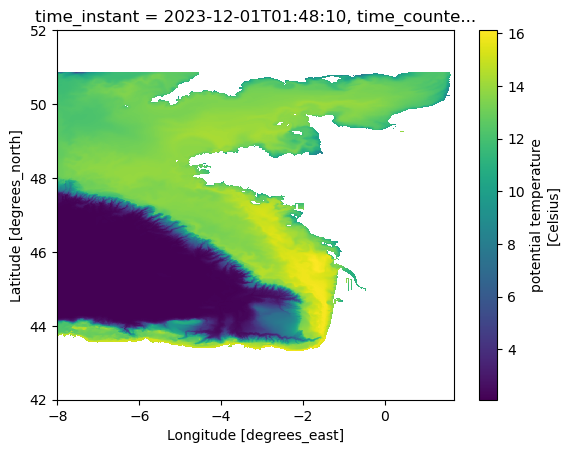

In [6]:
small_ds.temp.plot(y='nav_lat_rho', x='nav_lon_rho', ylim=(42, 52))

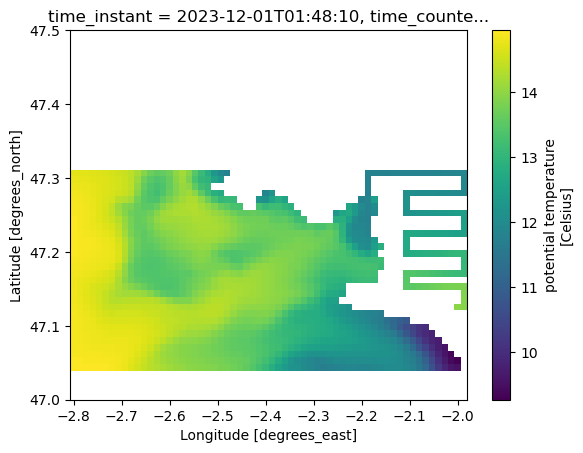

In [7]:
small_ds.temp.isel(x_rho =slice(390,452),y_rho =slice(400,430)).plot(
    y='nav_lat_rho', x='nav_lon_rho', ylim=(47, 47.5))